# REINFORCE and REINFORCE with baseline Tutorial
In this notebook you can find implementations for the Monte-Carlo based Reinforcement Learning algorithms, REINFORCE and REINFORCE with baseline as they are introduced in the book by Sutton & Barto, Reinforcement Learning An Introduction (Second edition). The two algorithms are derived from the *Policy Gradient Theorem* that is introduced in Chapter 13 in the book. It is important to note that both algorithms come to tackle environments with discrete action spaces, that when working with the *Gymnasium* (Formerly known as Gym) package are introduced as `Discrete(n)` objects, where $n$ is the number of discrete actions an agent can take in the environmnet.

Specifically in this notebook, we will work with the *LunarLander-v2* environment illustrated below, borrowed from the [LunarLander Gymnasium webpage](https://gymnasium.farama.org/environments/box2d/lunar_lander/)

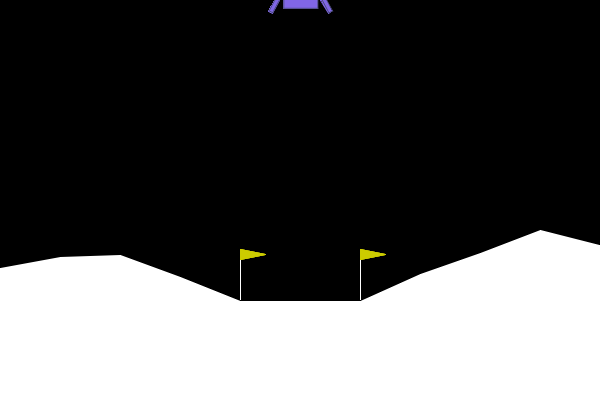

So, let's start.

In [1]:
from gymnasium.envs import box2d

**Note:**
In case the above command throws an error, follow the next two links to solve the problem:
- [Installing Box2D](https://pypi.org/project/Box2D/)

with ```pip install Box2D```

- [Uninstall and reinstall box2d-py](https://stackoverflow.com/questions/50037674/attributeerror-module-box2d-has-no-attribute-rand-limit-swigconstant)

then run ```pip uninstall box2d-py```, and ```pip install box2d-py```

In [2]:
## Incomment the installation commands below only if running from Google Colab
## In case running locally, all the needed packages are listed in the requirements.txt in the main directory.

# !pip install -q torch
# !pip install -q gymnasium[box2d]

## Imports
We will use the PyTorch package for the Policy and Value-function approximations using neural networks.

In [3]:
import numpy as np
import torch as T
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import gymnasium as gym
import matplotlib.pyplot as plt

# Gymnasium Check

First, let us try the environment using a random agent, just to get the feel of it.

In [4]:
# define scores and number of episodes
scores = []
avg_scores = []
max_steps = 100
n_episodes = 100

# create the environment
env = gym.make(
    "LunarLander-v2",
    continuous=False,
    gravity=-10.0,
    enable_wind=False,
    wind_power=15.0,
    turbulence_power=1.5)

# loop of n episodes
for episode in range(n_episodes):
    observation, info = env.reset(options={"randomize": True})
    done = False
    score = 0
    steps = 0
    
    # a single episode loop
    while not done:
        steps += 1  
        action = env.action_space.sample()  # this is where you would later insert your policy 
        next_observation, reward, terminated, truncated, info = env.step(action)
        score += reward
        observation = next_observation

        if terminated or truncated or steps == max_steps:
            done = True
            scores.append(score)
            avg_scores.append(np.mean(scores[-100:]))
    print(f'| Episode: {episode:4} | Score: {score:2.3f} | Avg score: {avg_scores[-1]:2.3f} |')
env.close()

| Episode:    0 | Score: -48.019 | Avg score: -48.019 |
| Episode:    1 | Score: -156.441 | Avg score: -102.230 |
| Episode:    2 | Score: -192.369 | Avg score: -132.276 |
| Episode:    3 | Score: -389.006 | Avg score: -196.459 |
| Episode:    4 | Score: -94.024 | Avg score: -175.972 |
| Episode:    5 | Score: -347.874 | Avg score: -204.622 |
| Episode:    6 | Score: -76.242 | Avg score: -186.282 |
| Episode:    7 | Score: -335.093 | Avg score: -204.884 |
| Episode:    8 | Score: -187.118 | Avg score: -202.910 |
| Episode:    9 | Score: -134.161 | Avg score: -196.035 |
| Episode:   10 | Score: -365.612 | Avg score: -211.451 |
| Episode:   11 | Score: -221.614 | Avg score: -212.298 |
| Episode:   12 | Score: -78.825 | Avg score: -202.031 |
| Episode:   13 | Score: -183.536 | Avg score: -200.710 |
| Episode:   14 | Score: -98.892 | Avg score: -193.922 |
| Episode:   15 | Score: -48.226 | Avg score: -184.816 |
| Episode:   16 | Score: -21.917 | Avg score: -175.233 |
| Episode:   17 | Scor

Plot the results of the random agent

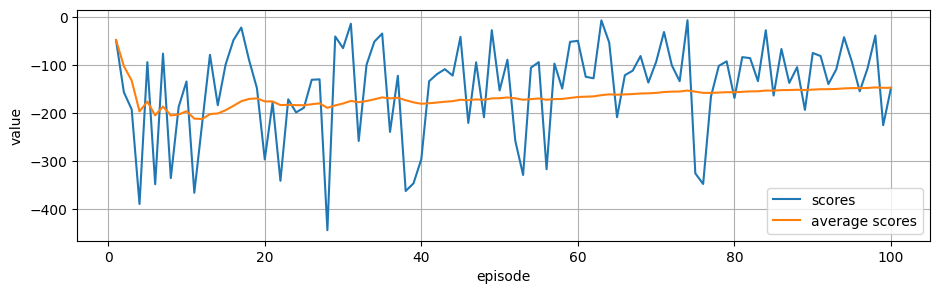

In [5]:
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(11, 3))
ax.plot(range(1, len(scores) + 1), scores, label='scores')
ax.plot(range(1, len(avg_scores) + 1), avg_scores, label='average scores')
ax.set_xlabel('episode')
ax.set_ylabel('value')
ax.legend()
ax.grid()
plt.show()

Check out the dimensions of the action and state spaces.

In [6]:
print(f'Observation info:\n{env.observation_space}')
print(f'Observation:\n{observation}')

print(f'\n\nAction info:\n{env.action_space}')
print(f'Action:\n{action}')

Observation info:
Box([-90.        -90.         -5.         -5.         -3.1415927  -5.
  -0.         -0.       ], [90.        90.         5.         5.         3.1415927  5.
  1.         1.       ], (8,), float32)
Observation:
[ 0.49469548 -0.02880101  0.9886773  -0.5470102  -0.42172095  3.8812222
  1.          0.        ]


Action info:
Discrete(4)
Action:
2


## REINFORCE: Monte-Carlo Policy Gradient algorithm
Next, we follow the *REINFORCE: Monte-Carlo Policy Gradient* algorithm as introduced in Chapter 13.3 (page 326) in the book. 
Here is the algorithm
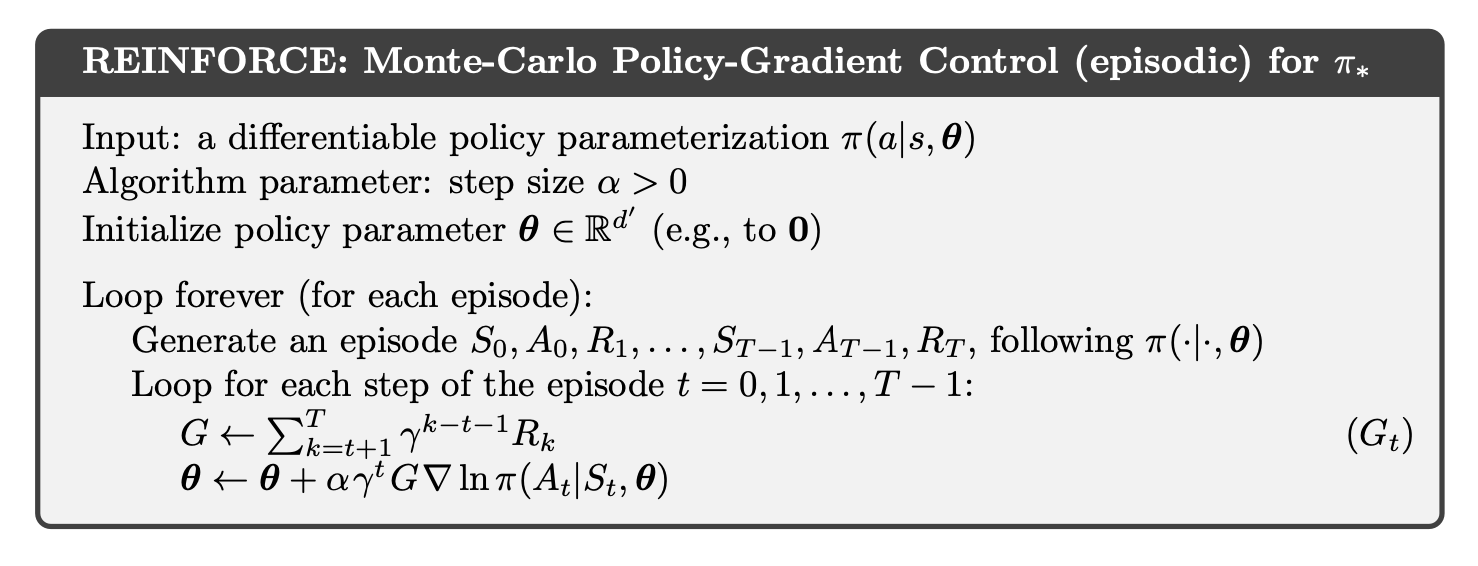

We begin by writing down the Policy network.

In [7]:
# The policy network
class PolicyNetwork(nn.Module):
    def __init__(self, input_dim, output_dim, learning_rate, fc1_dim, fc2_dim):
        super(PolicyNetwork, self).__init__()
        self.fc1 = nn.Linear(in_features=input_dim, out_features=fc1_dim)
        self.fc2 = nn.Linear(in_features=fc1_dim, out_features=fc2_dim)
        self.fc3 = nn.Linear(fc2_dim, output_dim)
        self.lr = learning_rate
        
        # it is good practice to define each neural network with its own optimizer and device
        self.optimizer = optim.Adam(params=self.parameters(), lr=self.lr)
        self.device = ('cuda:0' if T.cuda.is_available() else 'cpu')
        self.to(self.device)

    def forward(self, x):
        x = self.fc1(x)
        x = F.relu(x)
        x = self.fc2(x)
        x = F.relu(x)
        x = self.fc3(x)
        p = F.softmax(x, dim=-1)
        return p

Next, we define the REINFORCE agent.

In [12]:
class ReinforceAgent:
    def __init__(self, observation_dim, action_dim, lr_policy, gamma, fc1_dim, fc2_dim):
        self.action_dim = action_dim
        self.lr_policy = lr_policy
        self.gamma = gamma
        self.observation_dim = observation_dim
        self.action_dim = action_dim

        # set empty list for episodic trajectory saving (because it is a Monte-Carlo based algorithm)
        self.episode_rewards = []
        self.episode_reverse_log_probs = []
        self.episode_returns = []
        self.episode_values = []
        self.epsiode_log_probs = []

        # set the Policy network
        self.policy = PolicyNetwork(input_dim=observation_dim, 
                                    output_dim=action_dim, 
                                    learning_rate=lr_policy, fc1_dim=fc1_dim, 
                                    fc2_dim=fc2_dim)

    def reset(self):
        # reset after each episode+learn step
        self.episode_rewards = []
        self.episode_returns = []
        self.episode_reverse_log_probs = []
        self.epsiode_log_probs = []


    def choose_action(self, observation):
        # chooses an action
        observation = T.from_numpy(observation).float().to(self.policy.device) # send to the policy device 
        probs = self.policy(observation)                                       # compute probabilities for actions
        m = T.distributions.Categorical(probs=probs)                           # define a Categorical distribution
        action = m.sample()                                                    # sample the distribution for an action
        return action.item(), m.log_prob(action)

    def store_transition(self, reward, log_probs):
        # store a transition
        self.episode_rewards.append(reward)
        self.epsiode_log_probs.append(log_probs)

    def end_game_computation(self):
        # run after each episode
        t_terminal = len(self.episode_rewards)
        G = 0
        
        # loop for all time steps and compute the return for each state in reverse
        for t in range(t_terminal-1, -1, -1):
            G = self.episode_rewards[t] + self.gamma * G
            self.episode_returns.append(G)
            self.episode_reverse_log_probs.append(self.epsiode_log_probs[t])

        self.episode_returns = T.Tensor(self.episode_returns).to(self.policy.device)
        self.episode_reverse_log_probs = T.stack(self.episode_reverse_log_probs).squeeze()

    def learn(self):
        # learn function to run after each episode

        # train the policy
        # Notice the minus sign before the 'delta' value, that is because would implement gradient 
        # ascent instead of descent
        G = self.episode_returns
        policy_loss = T.sum(-G * self.episode_reverse_log_probs).to(self.policy.device) 
        self.policy.optimizer.zero_grad()
        policy_loss.backward()
        self.policy.optimizer.step()



### Run the environment with the RL agent

In [13]:
# define hyperparameters
MAX_STEPS = 150
N_EPISODES = 600
EXPERIMENTS = 5
OBSERVATION_DIM = 8
ACTION_DIM = 4
LR_POLICY = 1e-3
GAMMA = 0.99
FC1_DIM = 256
FC2_DIM = 256


scores = []
avg_scores = []
std_scores = []


# run experiments for all seeds
for i, experiment in enumerate(range(EXPERIMENTS)):
    scores.append([])
    avg_scores.append([])
    std_scores.append([])
    
    # initialize environment
    env = gym.make(
        "LunarLander-v2",
        continuous=False,
        gravity=-10.0,
        enable_wind=False,
        wind_power=0.0,
        turbulence_power=0.0)

    # initialize the agent
    reinforce_agent = ReinforceAgent(observation_dim=OBSERVATION_DIM, 
                                     action_dim=ACTION_DIM, 
                                     lr_policy=LR_POLICY, 
                                     gamma=GAMMA, 
                                     fc1_dim=FC1_DIM, fc2_dim=FC2_DIM)

    
    # loop for n episodes
    for episode in range(N_EPISODES):
        observation, info = env.reset()
        reinforce_agent.reset()
        done = False
        score = 0
        steps = 0
        
        # single episode loop
        while not done:
            steps += 1  
            action, probs = reinforce_agent.choose_action(observation)  
            next_observation, reward, terminated, truncated, info = env.step(action)
            score += reward
            reinforce_agent.store_transition(reward, probs)
            observation = next_observation
            
            # check for termination
            if terminated or truncated or steps == MAX_STEPS:
                done = True
                scores[i].append(score)
                avg_scores[i].append(np.mean(scores[i][-100:]))
                std_scores[i].append(np.std(scores[i][-100:]))

        print(f'| Experiment: {experiment + 1:4} | Episode: {episode:4} | Score: {np.round(score, 2):2.3f} | Avg score: {np.round(avg_scores[i][-1], 2):2.3f} |')
        reinforce_agent.end_game_computation()
        reinforce_agent.learn()
    env.close()

| Experiment:    1 | Episode:    0 | Score: 22.810 | Avg score: 22.810 |
| Experiment:    1 | Episode:    1 | Score: -69.080 | Avg score: -23.140 |
| Experiment:    1 | Episode:    2 | Score: -248.640 | Avg score: -98.300 |
| Experiment:    1 | Episode:    3 | Score: -158.540 | Avg score: -113.360 |
| Experiment:    1 | Episode:    4 | Score: -81.700 | Avg score: -107.030 |
| Experiment:    1 | Episode:    5 | Score: -379.230 | Avg score: -152.400 |
| Experiment:    1 | Episode:    6 | Score: -297.410 | Avg score: -173.110 |
| Experiment:    1 | Episode:    7 | Score: -456.180 | Avg score: -208.500 |
| Experiment:    1 | Episode:    8 | Score: -105.140 | Avg score: -197.010 |
| Experiment:    1 | Episode:    9 | Score: -270.130 | Avg score: -204.320 |
| Experiment:    1 | Episode:   10 | Score: -81.150 | Avg score: -193.130 |
| Experiment:    1 | Episode:   11 | Score: -99.930 | Avg score: -185.360 |
| Experiment:    1 | Episode:   12 | Score: -165.160 | Avg score: -183.810 |
| Experim

| Experiment:    1 | Episode:  107 | Score: -404.450 | Avg score: -226.010 |
| Experiment:    1 | Episode:  108 | Score: -166.480 | Avg score: -226.630 |
| Experiment:    1 | Episode:  109 | Score: -55.490 | Avg score: -224.480 |
| Experiment:    1 | Episode:  110 | Score: -203.870 | Avg score: -225.710 |
| Experiment:    1 | Episode:  111 | Score: -120.250 | Avg score: -225.910 |
| Experiment:    1 | Episode:  112 | Score: -97.080 | Avg score: -225.230 |
| Experiment:    1 | Episode:  113 | Score: -221.360 | Avg score: -224.770 |
| Experiment:    1 | Episode:  114 | Score: -249.070 | Avg score: -224.600 |
| Experiment:    1 | Episode:  115 | Score: -222.230 | Avg score: -225.570 |
| Experiment:    1 | Episode:  116 | Score: -63.150 | Avg score: -223.670 |
| Experiment:    1 | Episode:  117 | Score: -55.110 | Avg score: -220.970 |
| Experiment:    1 | Episode:  118 | Score: -362.050 | Avg score: -221.410 |
| Experiment:    1 | Episode:  119 | Score: -579.710 | Avg score: -225.030 |
| E

| Experiment:    1 | Episode:  220 | Score: -33.320 | Avg score: -173.050 |
| Experiment:    1 | Episode:  221 | Score: -221.140 | Avg score: -174.780 |
| Experiment:    1 | Episode:  222 | Score: -104.180 | Avg score: -174.010 |
| Experiment:    1 | Episode:  223 | Score: -135.860 | Avg score: -171.450 |
| Experiment:    1 | Episode:  224 | Score: -149.220 | Avg score: -170.450 |
| Experiment:    1 | Episode:  225 | Score: -97.090 | Avg score: -165.520 |
| Experiment:    1 | Episode:  226 | Score: -114.510 | Avg score: -163.960 |
| Experiment:    1 | Episode:  227 | Score: -94.180 | Avg score: -164.370 |
| Experiment:    1 | Episode:  228 | Score: -146.180 | Avg score: -164.180 |
| Experiment:    1 | Episode:  229 | Score: -92.180 | Avg score: -161.450 |
| Experiment:    1 | Episode:  230 | Score: -64.160 | Avg score: -161.320 |
| Experiment:    1 | Episode:  231 | Score: -76.310 | Avg score: -159.040 |
| Experiment:    1 | Episode:  232 | Score: -156.890 | Avg score: -159.520 |
| Exp

| Experiment:    1 | Episode:  333 | Score: -598.140 | Avg score: -345.590 |
| Experiment:    1 | Episode:  334 | Score: -968.600 | Avg score: -354.000 |
| Experiment:    1 | Episode:  335 | Score: -567.910 | Avg score: -358.820 |
| Experiment:    1 | Episode:  336 | Score: -458.510 | Avg score: -362.320 |
| Experiment:    1 | Episode:  337 | Score: -380.960 | Avg score: -365.830 |
| Experiment:    1 | Episode:  338 | Score: -565.380 | Avg score: -369.340 |
| Experiment:    1 | Episode:  339 | Score: -1107.570 | Avg score: -379.610 |
| Experiment:    1 | Episode:  340 | Score: -379.450 | Avg score: -380.250 |
| Experiment:    1 | Episode:  341 | Score: -532.740 | Avg score: -384.590 |
| Experiment:    1 | Episode:  342 | Score: -582.140 | Avg score: -388.400 |
| Experiment:    1 | Episode:  343 | Score: -1013.760 | Avg score: -397.470 |
| Experiment:    1 | Episode:  344 | Score: -680.820 | Avg score: -400.640 |
| Experiment:    1 | Episode:  345 | Score: -608.750 | Avg score: -403.760

| Experiment:    1 | Episode:  442 | Score: -780.060 | Avg score: -684.160 |
| Experiment:    1 | Episode:  443 | Score: -682.490 | Avg score: -680.850 |
| Experiment:    1 | Episode:  444 | Score: -946.170 | Avg score: -683.500 |
| Experiment:    1 | Episode:  445 | Score: -526.310 | Avg score: -682.680 |
| Experiment:    1 | Episode:  446 | Score: -984.730 | Avg score: -687.520 |
| Experiment:    1 | Episode:  447 | Score: -713.180 | Avg score: -687.550 |
| Experiment:    1 | Episode:  448 | Score: -660.980 | Avg score: -689.830 |
| Experiment:    1 | Episode:  449 | Score: -820.240 | Avg score: -691.580 |
| Experiment:    1 | Episode:  450 | Score: -824.860 | Avg score: -692.950 |
| Experiment:    1 | Episode:  451 | Score: -560.070 | Avg score: -689.580 |
| Experiment:    1 | Episode:  452 | Score: -531.130 | Avg score: -685.910 |
| Experiment:    1 | Episode:  453 | Score: -700.580 | Avg score: -681.850 |
| Experiment:    1 | Episode:  454 | Score: -918.710 | Avg score: -685.730 |

| Experiment:    1 | Episode:  553 | Score: -911.680 | Avg score: -662.810 |
| Experiment:    1 | Episode:  554 | Score: -974.690 | Avg score: -663.370 |
| Experiment:    1 | Episode:  555 | Score: -554.400 | Avg score: -661.760 |
| Experiment:    1 | Episode:  556 | Score: -1080.140 | Avg score: -669.030 |
| Experiment:    1 | Episode:  557 | Score: -467.620 | Avg score: -666.220 |
| Experiment:    1 | Episode:  558 | Score: -622.030 | Avg score: -667.080 |
| Experiment:    1 | Episode:  559 | Score: -831.430 | Avg score: -671.370 |
| Experiment:    1 | Episode:  560 | Score: -647.170 | Avg score: -671.300 |
| Experiment:    1 | Episode:  561 | Score: -764.140 | Avg score: -670.980 |
| Experiment:    1 | Episode:  562 | Score: -788.340 | Avg score: -673.830 |
| Experiment:    1 | Episode:  563 | Score: -546.900 | Avg score: -673.220 |
| Experiment:    1 | Episode:  564 | Score: -591.610 | Avg score: -674.170 |
| Experiment:    1 | Episode:  565 | Score: -842.540 | Avg score: -672.970 

| Experiment:    2 | Episode:   63 | Score: -124.640 | Avg score: -189.390 |
| Experiment:    2 | Episode:   64 | Score: -102.740 | Avg score: -188.060 |
| Experiment:    2 | Episode:   65 | Score: -145.630 | Avg score: -187.420 |
| Experiment:    2 | Episode:   66 | Score: -292.120 | Avg score: -188.980 |
| Experiment:    2 | Episode:   67 | Score: -156.650 | Avg score: -188.500 |
| Experiment:    2 | Episode:   68 | Score: -156.120 | Avg score: -188.030 |
| Experiment:    2 | Episode:   69 | Score: -168.500 | Avg score: -187.760 |
| Experiment:    2 | Episode:   70 | Score: -107.120 | Avg score: -186.620 |
| Experiment:    2 | Episode:   71 | Score: -125.200 | Avg score: -185.770 |
| Experiment:    2 | Episode:   72 | Score: -174.130 | Avg score: -185.610 |
| Experiment:    2 | Episode:   73 | Score: -98.140 | Avg score: -184.430 |
| Experiment:    2 | Episode:   74 | Score: -212.030 | Avg score: -184.790 |
| Experiment:    2 | Episode:   75 | Score: -151.590 | Avg score: -184.360 |


| Experiment:    2 | Episode:  173 | Score: -56.450 | Avg score: -129.120 |
| Experiment:    2 | Episode:  174 | Score: -28.450 | Avg score: -127.280 |
| Experiment:    2 | Episode:  175 | Score: -98.460 | Avg score: -126.750 |
| Experiment:    2 | Episode:  176 | Score: -267.470 | Avg score: -128.700 |
| Experiment:    2 | Episode:  177 | Score: -45.640 | Avg score: -127.720 |
| Experiment:    2 | Episode:  178 | Score: -73.760 | Avg score: -127.320 |
| Experiment:    2 | Episode:  179 | Score: -196.340 | Avg score: -128.190 |
| Experiment:    2 | Episode:  180 | Score: -121.260 | Avg score: -128.380 |
| Experiment:    2 | Episode:  181 | Score: -144.250 | Avg score: -128.630 |
| Experiment:    2 | Episode:  182 | Score: -12.600 | Avg score: -127.670 |
| Experiment:    2 | Episode:  183 | Score: -188.060 | Avg score: -128.490 |
| Experiment:    2 | Episode:  184 | Score: -327.320 | Avg score: -130.400 |
| Experiment:    2 | Episode:  185 | Score: -15.340 | Avg score: -129.130 |
| Expe

| Experiment:    2 | Episode:  281 | Score: -69.730 | Avg score: -162.490 |
| Experiment:    2 | Episode:  282 | Score: -1.600 | Avg score: -162.380 |
| Experiment:    2 | Episode:  283 | Score: -79.820 | Avg score: -161.290 |
| Experiment:    2 | Episode:  284 | Score: -218.730 | Avg score: -160.210 |
| Experiment:    2 | Episode:  285 | Score: -292.340 | Avg score: -162.980 |
| Experiment:    2 | Episode:  286 | Score: -247.010 | Avg score: -164.390 |
| Experiment:    2 | Episode:  287 | Score: -280.870 | Avg score: -165.520 |
| Experiment:    2 | Episode:  288 | Score: -342.270 | Avg score: -168.450 |
| Experiment:    2 | Episode:  289 | Score: -52.120 | Avg score: -167.070 |
| Experiment:    2 | Episode:  290 | Score: -159.870 | Avg score: -168.420 |
| Experiment:    2 | Episode:  291 | Score: -10.380 | Avg score: -167.970 |
| Experiment:    2 | Episode:  292 | Score: -37.660 | Avg score: -166.320 |
| Experiment:    2 | Episode:  293 | Score: -65.190 | Avg score: -166.570 |
| Exper

| Experiment:    2 | Episode:  390 | Score: -16.610 | Avg score: -83.610 |
| Experiment:    2 | Episode:  391 | Score: -114.670 | Avg score: -84.660 |
| Experiment:    2 | Episode:  392 | Score: -20.130 | Avg score: -84.480 |
| Experiment:    2 | Episode:  393 | Score: 137.400 | Avg score: -82.450 |
| Experiment:    2 | Episode:  394 | Score: -136.680 | Avg score: -83.050 |
| Experiment:    2 | Episode:  395 | Score: -149.840 | Avg score: -83.780 |
| Experiment:    2 | Episode:  396 | Score: -119.420 | Avg score: -84.300 |
| Experiment:    2 | Episode:  397 | Score: 46.430 | Avg score: -83.290 |
| Experiment:    2 | Episode:  398 | Score: -229.660 | Avg score: -84.690 |
| Experiment:    2 | Episode:  399 | Score: -34.760 | Avg score: -84.250 |
| Experiment:    2 | Episode:  400 | Score: -85.590 | Avg score: -84.570 |
| Experiment:    2 | Episode:  401 | Score: -65.330 | Avg score: -84.440 |
| Experiment:    2 | Episode:  402 | Score: -12.460 | Avg score: -83.720 |
| Experiment:    2 | 

| Experiment:    2 | Episode:  501 | Score: 131.800 | Avg score: -48.660 |
| Experiment:    2 | Episode:  502 | Score: 50.370 | Avg score: -48.040 |
| Experiment:    2 | Episode:  503 | Score: -251.500 | Avg score: -49.440 |
| Experiment:    2 | Episode:  504 | Score: 5.830 | Avg score: -47.480 |
| Experiment:    2 | Episode:  505 | Score: 110.510 | Avg score: -46.100 |
| Experiment:    2 | Episode:  506 | Score: 45.400 | Avg score: -45.510 |
| Experiment:    2 | Episode:  507 | Score: -20.780 | Avg score: -46.560 |
| Experiment:    2 | Episode:  508 | Score: 3.240 | Avg score: -44.950 |
| Experiment:    2 | Episode:  509 | Score: 84.290 | Avg score: -42.870 |
| Experiment:    2 | Episode:  510 | Score: -44.760 | Avg score: -44.150 |
| Experiment:    2 | Episode:  511 | Score: 5.510 | Avg score: -43.820 |
| Experiment:    2 | Episode:  512 | Score: 90.760 | Avg score: -40.270 |
| Experiment:    2 | Episode:  513 | Score: -81.260 | Avg score: -42.140 |
| Experiment:    2 | Episode:  514

| Experiment:    3 | Episode:   19 | Score: -195.430 | Avg score: -231.830 |
| Experiment:    3 | Episode:   20 | Score: -394.970 | Avg score: -239.590 |
| Experiment:    3 | Episode:   21 | Score: -330.730 | Avg score: -243.740 |
| Experiment:    3 | Episode:   22 | Score: -266.440 | Avg score: -244.720 |
| Experiment:    3 | Episode:   23 | Score: -114.590 | Avg score: -239.300 |
| Experiment:    3 | Episode:   24 | Score: -209.910 | Avg score: -238.130 |
| Experiment:    3 | Episode:   25 | Score: -210.460 | Avg score: -237.060 |
| Experiment:    3 | Episode:   26 | Score: -285.640 | Avg score: -238.860 |
| Experiment:    3 | Episode:   27 | Score: -515.000 | Avg score: -248.720 |
| Experiment:    3 | Episode:   28 | Score: -423.790 | Avg score: -254.760 |
| Experiment:    3 | Episode:   29 | Score: -613.290 | Avg score: -266.710 |
| Experiment:    3 | Episode:   30 | Score: -160.830 | Avg score: -263.300 |
| Experiment:    3 | Episode:   31 | Score: -258.750 | Avg score: -263.150 |

| Experiment:    3 | Episode:  134 | Score: -121.150 | Avg score: -157.650 |
| Experiment:    3 | Episode:  135 | Score: -552.000 | Avg score: -160.700 |
| Experiment:    3 | Episode:  136 | Score: -291.050 | Avg score: -161.630 |
| Experiment:    3 | Episode:  137 | Score: -359.310 | Avg score: -162.100 |
| Experiment:    3 | Episode:  138 | Score: -134.900 | Avg score: -161.870 |
| Experiment:    3 | Episode:  139 | Score: -193.650 | Avg score: -162.850 |
| Experiment:    3 | Episode:  140 | Score: -411.790 | Avg score: -162.980 |
| Experiment:    3 | Episode:  141 | Score: -112.960 | Avg score: -163.110 |
| Experiment:    3 | Episode:  142 | Score: -151.240 | Avg score: -163.490 |
| Experiment:    3 | Episode:  143 | Score: -409.220 | Avg score: -166.280 |
| Experiment:    3 | Episode:  144 | Score: -161.330 | Avg score: -166.730 |
| Experiment:    3 | Episode:  145 | Score: -148.010 | Avg score: -165.760 |
| Experiment:    3 | Episode:  146 | Score: -141.010 | Avg score: -165.070 |

| Experiment:    3 | Episode:  242 | Score: -13.260 | Avg score: -159.640 |
| Experiment:    3 | Episode:  243 | Score: -115.120 | Avg score: -156.700 |
| Experiment:    3 | Episode:  244 | Score: 13.840 | Avg score: -154.950 |
| Experiment:    3 | Episode:  245 | Score: -82.150 | Avg score: -154.290 |
| Experiment:    3 | Episode:  246 | Score: -360.700 | Avg score: -156.490 |
| Experiment:    3 | Episode:  247 | Score: -116.070 | Avg score: -156.400 |
| Experiment:    3 | Episode:  248 | Score: -85.810 | Avg score: -155.830 |
| Experiment:    3 | Episode:  249 | Score: -76.250 | Avg score: -153.680 |
| Experiment:    3 | Episode:  250 | Score: -57.750 | Avg score: -153.260 |
| Experiment:    3 | Episode:  251 | Score: -102.520 | Avg score: -152.860 |
| Experiment:    3 | Episode:  252 | Score: -94.970 | Avg score: -152.350 |
| Experiment:    3 | Episode:  253 | Score: -74.370 | Avg score: -151.820 |
| Experiment:    3 | Episode:  254 | Score: -60.190 | Avg score: -151.040 |
| Experim

| Experiment:    3 | Episode:  357 | Score: -173.810 | Avg score: -127.400 |
| Experiment:    3 | Episode:  358 | Score: -105.810 | Avg score: -127.430 |
| Experiment:    3 | Episode:  359 | Score: -107.830 | Avg score: -126.970 |
| Experiment:    3 | Episode:  360 | Score: -280.480 | Avg score: -130.340 |
| Experiment:    3 | Episode:  361 | Score: -131.800 | Avg score: -130.620 |
| Experiment:    3 | Episode:  362 | Score: -143.900 | Avg score: -129.960 |
| Experiment:    3 | Episode:  363 | Score: 3.590 | Avg score: -128.680 |
| Experiment:    3 | Episode:  364 | Score: -136.490 | Avg score: -129.000 |
| Experiment:    3 | Episode:  365 | Score: -118.160 | Avg score: -129.380 |
| Experiment:    3 | Episode:  366 | Score: -135.760 | Avg score: -129.950 |
| Experiment:    3 | Episode:  367 | Score: -126.020 | Avg score: -129.940 |
| Experiment:    3 | Episode:  368 | Score: -156.550 | Avg score: -130.680 |
| Experiment:    3 | Episode:  369 | Score: -124.290 | Avg score: -130.730 |
| 

| Experiment:    3 | Episode:  467 | Score: -94.410 | Avg score: -136.180 |
| Experiment:    3 | Episode:  468 | Score: -204.520 | Avg score: -136.660 |
| Experiment:    3 | Episode:  469 | Score: -71.800 | Avg score: -136.130 |
| Experiment:    3 | Episode:  470 | Score: -108.650 | Avg score: -135.950 |
| Experiment:    3 | Episode:  471 | Score: -150.930 | Avg score: -136.020 |
| Experiment:    3 | Episode:  472 | Score: -142.190 | Avg score: -136.200 |
| Experiment:    3 | Episode:  473 | Score: -169.260 | Avg score: -133.670 |
| Experiment:    3 | Episode:  474 | Score: -113.620 | Avg score: -133.790 |
| Experiment:    3 | Episode:  475 | Score: -246.800 | Avg score: -135.100 |
| Experiment:    3 | Episode:  476 | Score: -103.120 | Avg score: -135.120 |
| Experiment:    3 | Episode:  477 | Score: -73.740 | Avg score: -134.730 |
| Experiment:    3 | Episode:  478 | Score: -142.390 | Avg score: -134.770 |
| Experiment:    3 | Episode:  479 | Score: -121.490 | Avg score: -134.710 |
| 

| Experiment:    3 | Episode:  578 | Score: -207.600 | Avg score: -126.670 |
| Experiment:    3 | Episode:  579 | Score: -108.700 | Avg score: -126.540 |
| Experiment:    3 | Episode:  580 | Score: -97.730 | Avg score: -126.420 |
| Experiment:    3 | Episode:  581 | Score: -123.140 | Avg score: -126.750 |
| Experiment:    3 | Episode:  582 | Score: -105.640 | Avg score: -126.740 |
| Experiment:    3 | Episode:  583 | Score: -145.480 | Avg score: -127.010 |
| Experiment:    3 | Episode:  584 | Score: -113.330 | Avg score: -126.650 |
| Experiment:    3 | Episode:  585 | Score: -168.970 | Avg score: -126.660 |
| Experiment:    3 | Episode:  586 | Score: -85.290 | Avg score: -125.820 |
| Experiment:    3 | Episode:  587 | Score: -124.140 | Avg score: -125.240 |
| Experiment:    3 | Episode:  588 | Score: -151.030 | Avg score: -125.670 |
| Experiment:    3 | Episode:  589 | Score: -159.530 | Avg score: -126.090 |
| Experiment:    3 | Episode:  590 | Score: -108.310 | Avg score: -126.100 |
|

| Experiment:    4 | Episode:   85 | Score: -442.250 | Avg score: -287.160 |
| Experiment:    4 | Episode:   86 | Score: -339.960 | Avg score: -287.770 |
| Experiment:    4 | Episode:   87 | Score: -142.470 | Avg score: -286.120 |
| Experiment:    4 | Episode:   88 | Score: -460.120 | Avg score: -288.070 |
| Experiment:    4 | Episode:   89 | Score: -372.430 | Avg score: -289.010 |
| Experiment:    4 | Episode:   90 | Score: -439.290 | Avg score: -290.660 |
| Experiment:    4 | Episode:   91 | Score: -486.850 | Avg score: -292.790 |
| Experiment:    4 | Episode:   92 | Score: -221.630 | Avg score: -292.030 |
| Experiment:    4 | Episode:   93 | Score: -373.340 | Avg score: -292.890 |
| Experiment:    4 | Episode:   94 | Score: -134.020 | Avg score: -291.220 |
| Experiment:    4 | Episode:   95 | Score: -41.750 | Avg score: -288.620 |
| Experiment:    4 | Episode:   96 | Score: -263.230 | Avg score: -288.360 |
| Experiment:    4 | Episode:   97 | Score: -241.860 | Avg score: -287.890 |


| Experiment:    4 | Episode:  194 | Score: -107.410 | Avg score: -163.610 |
| Experiment:    4 | Episode:  195 | Score: -112.190 | Avg score: -164.310 |
| Experiment:    4 | Episode:  196 | Score: -74.500 | Avg score: -162.430 |
| Experiment:    4 | Episode:  197 | Score: -113.960 | Avg score: -161.150 |
| Experiment:    4 | Episode:  198 | Score: -249.320 | Avg score: -161.240 |
| Experiment:    4 | Episode:  199 | Score: -199.850 | Avg score: -161.060 |
| Experiment:    4 | Episode:  200 | Score: -201.790 | Avg score: -161.780 |
| Experiment:    4 | Episode:  201 | Score: -164.390 | Avg score: -160.500 |
| Experiment:    4 | Episode:  202 | Score: -86.070 | Avg score: -160.150 |
| Experiment:    4 | Episode:  203 | Score: -156.770 | Avg score: -160.430 |
| Experiment:    4 | Episode:  204 | Score: -73.110 | Avg score: -159.790 |
| Experiment:    4 | Episode:  205 | Score: -99.440 | Avg score: -159.350 |
| Experiment:    4 | Episode:  206 | Score: -140.120 | Avg score: -158.740 |
| E

| Experiment:    4 | Episode:  304 | Score: -93.050 | Avg score: -146.390 |
| Experiment:    4 | Episode:  305 | Score: -108.520 | Avg score: -146.480 |
| Experiment:    4 | Episode:  306 | Score: -176.540 | Avg score: -146.840 |
| Experiment:    4 | Episode:  307 | Score: -140.080 | Avg score: -144.170 |
| Experiment:    4 | Episode:  308 | Score: -107.350 | Avg score: -143.780 |
| Experiment:    4 | Episode:  309 | Score: -193.340 | Avg score: -142.410 |
| Experiment:    4 | Episode:  310 | Score: -9.040 | Avg score: -139.660 |
| Experiment:    4 | Episode:  311 | Score: -167.320 | Avg score: -139.570 |
| Experiment:    4 | Episode:  312 | Score: -134.530 | Avg score: -138.980 |
| Experiment:    4 | Episode:  313 | Score: -115.710 | Avg score: -138.980 |
| Experiment:    4 | Episode:  314 | Score: -178.430 | Avg score: -138.800 |
| Experiment:    4 | Episode:  315 | Score: -139.550 | Avg score: -138.920 |
| Experiment:    4 | Episode:  316 | Score: -179.180 | Avg score: -139.210 |
| 

| Experiment:    4 | Episode:  414 | Score: -110.000 | Avg score: -131.270 |
| Experiment:    4 | Episode:  415 | Score: -143.770 | Avg score: -131.310 |
| Experiment:    4 | Episode:  416 | Score: -51.830 | Avg score: -130.040 |
| Experiment:    4 | Episode:  417 | Score: -86.830 | Avg score: -129.840 |
| Experiment:    4 | Episode:  418 | Score: -200.320 | Avg score: -130.930 |
| Experiment:    4 | Episode:  419 | Score: -282.900 | Avg score: -132.740 |
| Experiment:    4 | Episode:  420 | Score: -5.560 | Avg score: -130.860 |
| Experiment:    4 | Episode:  421 | Score: -147.800 | Avg score: -130.030 |
| Experiment:    4 | Episode:  422 | Score: -195.350 | Avg score: -130.850 |
| Experiment:    4 | Episode:  423 | Score: -371.070 | Avg score: -133.540 |
| Experiment:    4 | Episode:  424 | Score: -162.400 | Avg score: -134.050 |
| Experiment:    4 | Episode:  425 | Score: -113.490 | Avg score: -133.700 |
| Experiment:    4 | Episode:  426 | Score: -189.020 | Avg score: -133.780 |
| E

| Experiment:    4 | Episode:  527 | Score: -95.410 | Avg score: -120.980 |
| Experiment:    4 | Episode:  528 | Score: -143.640 | Avg score: -119.520 |
| Experiment:    4 | Episode:  529 | Score: -115.090 | Avg score: -119.940 |
| Experiment:    4 | Episode:  530 | Score: -143.360 | Avg score: -120.340 |
| Experiment:    4 | Episode:  531 | Score: -132.820 | Avg score: -120.230 |
| Experiment:    4 | Episode:  532 | Score: -322.320 | Avg score: -122.360 |
| Experiment:    4 | Episode:  533 | Score: -127.700 | Avg score: -122.460 |
| Experiment:    4 | Episode:  534 | Score: -131.940 | Avg score: -122.550 |
| Experiment:    4 | Episode:  535 | Score: -134.620 | Avg score: -122.710 |
| Experiment:    4 | Episode:  536 | Score: -101.030 | Avg score: -123.020 |
| Experiment:    4 | Episode:  537 | Score: -130.570 | Avg score: -122.750 |
| Experiment:    4 | Episode:  538 | Score: -107.600 | Avg score: -122.280 |
| Experiment:    4 | Episode:  539 | Score: -118.140 | Avg score: -121.340 |


| Experiment:    5 | Episode:   36 | Score: -98.520 | Avg score: -197.970 |
| Experiment:    5 | Episode:   37 | Score: -119.220 | Avg score: -195.900 |
| Experiment:    5 | Episode:   38 | Score: -213.360 | Avg score: -196.340 |
| Experiment:    5 | Episode:   39 | Score: -117.740 | Avg score: -194.380 |
| Experiment:    5 | Episode:   40 | Score: -131.630 | Avg score: -192.850 |
| Experiment:    5 | Episode:   41 | Score: -230.520 | Avg score: -193.740 |
| Experiment:    5 | Episode:   42 | Score: -75.580 | Avg score: -191.000 |
| Experiment:    5 | Episode:   43 | Score: -102.990 | Avg score: -189.000 |
| Experiment:    5 | Episode:   44 | Score: -147.320 | Avg score: -188.070 |
| Experiment:    5 | Episode:   45 | Score: -108.670 | Avg score: -186.340 |
| Experiment:    5 | Episode:   46 | Score: -137.230 | Avg score: -185.300 |
| Experiment:    5 | Episode:   47 | Score: -313.140 | Avg score: -187.960 |
| Experiment:    5 | Episode:   48 | Score: -190.010 | Avg score: -188.000 |
|

| Experiment:    5 | Episode:  149 | Score: -149.050 | Avg score: -120.000 |
| Experiment:    5 | Episode:  150 | Score: -159.360 | Avg score: -120.450 |
| Experiment:    5 | Episode:  151 | Score: -233.380 | Avg score: -121.970 |
| Experiment:    5 | Episode:  152 | Score: -181.540 | Avg score: -122.300 |
| Experiment:    5 | Episode:  153 | Score: -279.050 | Avg score: -123.810 |
| Experiment:    5 | Episode:  154 | Score: 16.580 | Avg score: -122.330 |
| Experiment:    5 | Episode:  155 | Score: -263.320 | Avg score: -123.710 |
| Experiment:    5 | Episode:  156 | Score: -40.690 | Avg score: -123.050 |
| Experiment:    5 | Episode:  157 | Score: -55.530 | Avg score: -122.990 |
| Experiment:    5 | Episode:  158 | Score: -43.970 | Avg score: -122.420 |
| Experiment:    5 | Episode:  159 | Score: -41.600 | Avg score: -123.060 |
| Experiment:    5 | Episode:  160 | Score: -94.230 | Avg score: -120.840 |
| Experiment:    5 | Episode:  161 | Score: -273.070 | Avg score: -122.230 |
| Expe

| Experiment:    5 | Episode:  259 | Score: -34.420 | Avg score: -150.150 |
| Experiment:    5 | Episode:  260 | Score: -128.020 | Avg score: -150.490 |
| Experiment:    5 | Episode:  261 | Score: -75.380 | Avg score: -148.510 |
| Experiment:    5 | Episode:  262 | Score: -2.160 | Avg score: -148.390 |
| Experiment:    5 | Episode:  263 | Score: -349.260 | Avg score: -151.600 |
| Experiment:    5 | Episode:  264 | Score: -30.690 | Avg score: -150.530 |
| Experiment:    5 | Episode:  265 | Score: -79.670 | Avg score: -149.400 |
| Experiment:    5 | Episode:  266 | Score: -255.010 | Avg score: -150.920 |
| Experiment:    5 | Episode:  267 | Score: -3.160 | Avg score: -150.250 |
| Experiment:    5 | Episode:  268 | Score: -149.280 | Avg score: -148.880 |
| Experiment:    5 | Episode:  269 | Score: -207.530 | Avg score: -147.650 |
| Experiment:    5 | Episode:  270 | Score: -49.580 | Avg score: -146.480 |
| Experiment:    5 | Episode:  271 | Score: 106.690 | Avg score: -143.890 |
| Experim

| Experiment:    5 | Episode:  371 | Score: -16.060 | Avg score: -66.010 |
| Experiment:    5 | Episode:  372 | Score: -207.610 | Avg score: -67.730 |
| Experiment:    5 | Episode:  373 | Score: -77.250 | Avg score: -67.500 |
| Experiment:    5 | Episode:  374 | Score: -235.890 | Avg score: -68.760 |
| Experiment:    5 | Episode:  375 | Score: -36.810 | Avg score: -68.830 |
| Experiment:    5 | Episode:  376 | Score: 46.550 | Avg score: -68.330 |
| Experiment:    5 | Episode:  377 | Score: -77.820 | Avg score: -68.920 |
| Experiment:    5 | Episode:  378 | Score: -64.970 | Avg score: -67.360 |
| Experiment:    5 | Episode:  379 | Score: -50.730 | Avg score: -66.890 |
| Experiment:    5 | Episode:  380 | Score: -42.070 | Avg score: -66.910 |
| Experiment:    5 | Episode:  381 | Score: -43.380 | Avg score: -65.850 |
| Experiment:    5 | Episode:  382 | Score: -38.940 | Avg score: -66.060 |
| Experiment:    5 | Episode:  383 | Score: -39.100 | Avg score: -65.820 |
| Experiment:    5 | Epi

| Experiment:    5 | Episode:  488 | Score: 29.660 | Avg score: 14.270 |
| Experiment:    5 | Episode:  489 | Score: 51.400 | Avg score: 13.300 |
| Experiment:    5 | Episode:  490 | Score: 115.290 | Avg score: 14.700 |
| Experiment:    5 | Episode:  491 | Score: -10.190 | Avg score: 15.310 |
| Experiment:    5 | Episode:  492 | Score: 32.860 | Avg score: 15.620 |
| Experiment:    5 | Episode:  493 | Score: 92.380 | Avg score: 17.070 |
| Experiment:    5 | Episode:  494 | Score: 17.030 | Avg score: 17.670 |
| Experiment:    5 | Episode:  495 | Score: 75.240 | Avg score: 18.400 |
| Experiment:    5 | Episode:  496 | Score: 9.860 | Avg score: 18.860 |
| Experiment:    5 | Episode:  497 | Score: 122.790 | Avg score: 20.160 |
| Experiment:    5 | Episode:  498 | Score: 5.400 | Avg score: 20.350 |
| Experiment:    5 | Episode:  499 | Score: 74.450 | Avg score: 21.670 |
| Experiment:    5 | Episode:  500 | Score: 75.720 | Avg score: 22.430 |
| Experiment:    5 | Episode:  501 | Score: 85.870

In [14]:
def plot_results(avg_scores, std_scores):
    # plot the results from a set of experiments
    n_episodes = len(avg_scores[0])
    n_experiments = len(avg_scores)

    avg_scores = np.array(avg_scores)
    avg_avg_scores = np.mean(avg_scores, axis=0)
    std_avg_scores = np.std(avg_scores, axis=0)

    upper_std_scores = avg_avg_scores + std_avg_scores
    lower_std_scores = avg_avg_scores - std_avg_scores
    x = range(1, n_episodes + 1)

    fig, ax = plt.subplots(nrows=2, ncols=1, figsize=(11, 6), sharex=True)
    ax[0].set_title("Score averaged over different experiments")
    ax[0].plot(x, avg_avg_scores, label=f'average score')
    ax[0].fill_between(x, upper_std_scores, lower_std_scores, 
                    where=(upper_std_scores > lower_std_scores), alpha=0.3)

    for i in range(n_experiments):
        avg_scores_numpy = np.array(avg_scores[i])
        std_scores_numpy = np.array(std_scores[i])
        upper = avg_scores_numpy + std_scores_numpy
        lower = avg_scores_numpy - std_scores_numpy
        ax[1].plot(x, avg_scores_numpy, label=f'Exp-{i}')
        ax[1].fill_between(x, upper, lower, where=(upper > lower), alpha=0.3)

    ax[1].set_xlabel('episode')
    ax[0].set_ylabel('score')
    ax[1].set_ylabel('score')
    ax[0].legend()
    ax[0].grid()
    ax[1].legend()
    ax[1].grid()
    plt.show()

### Plot the results

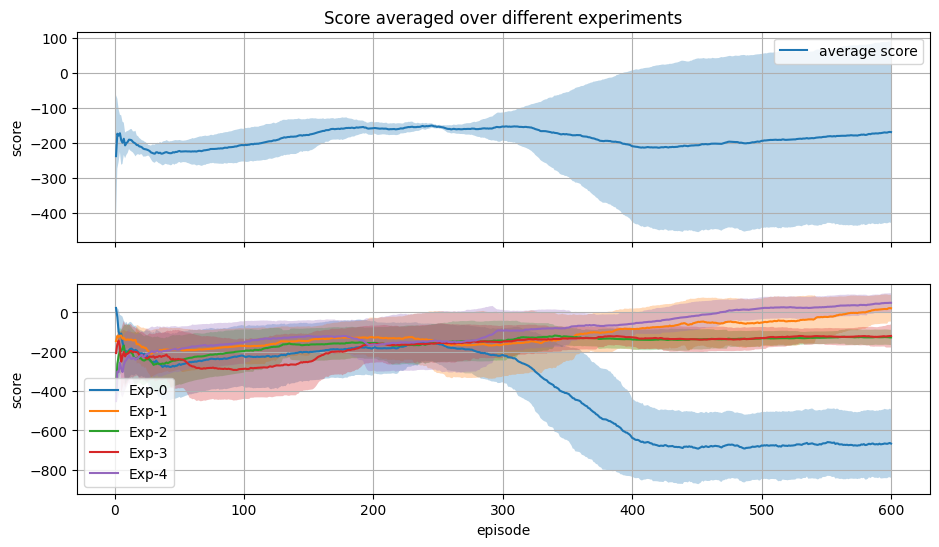

In [15]:
plot_results(avg_scores, std_scores)

## REINFORCE with baseline algorithm
Next, we follow the REINFORCE with baseline algorithm as introduced in Chapter 13 (page 329) in the book. 
Here is the algorithm
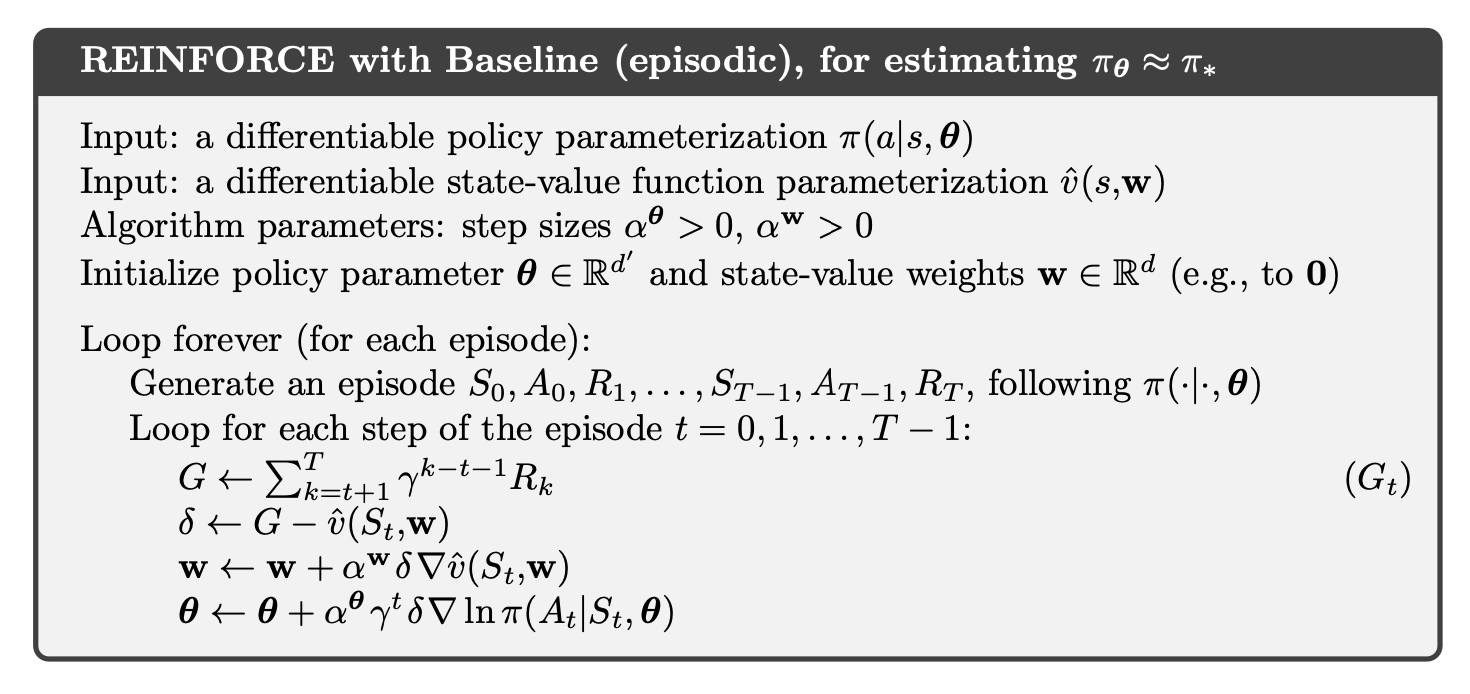

We begin by writing down the Policy and Value function networks.

In [16]:
# The policy network
class PolicyNetwork(nn.Module):
    def __init__(self, input_dim, output_dim, learning_rate, fc1_dim, fc2_dim):
        super(PolicyNetwork, self).__init__()
        self.fc1 = nn.Linear(in_features=input_dim, out_features=fc1_dim)
        self.fc2 = nn.Linear(in_features=fc1_dim, out_features=fc2_dim)
        self.fc3 = nn.Linear(fc2_dim, output_dim)
        self.lr = learning_rate
        
        # it is good practice to define each neural network with its own optimizer and device
        self.optimizer = optim.Adam(params=self.parameters(), lr=self.lr)
        self.device = ('cuda:0' if T.cuda.is_available() else 'cpu')
        self.to(self.device)

    def forward(self, x):
        x = self.fc1(x)
        x = F.relu(x)
        x = self.fc2(x)
        x = F.relu(x)
        x = self.fc3(x)
        p = F.softmax(x, dim=-1)
        return p

    
# The value function network
class ValueNetwork(nn.Module):
    def __init__(self, input_dim, output_dim, learning_rate, fc1_dim, fc2_dim):
        super(ValueNetwork, self).__init__()
        self.fc1 = nn.Linear(in_features=input_dim, out_features=fc1_dim)
        self.fc2 = nn.Linear(in_features=fc1_dim, out_features=fc2_dim)
        self.fc3 = nn.Linear(fc2_dim, output_dim)
        self.lr = learning_rate

        self.optimizer = optim.Adam(params=self.parameters(), lr=self.lr)
        self.device = ('cuda:0' if T.cuda.is_available() else 'cpu')
        self.to(self.device)

    def forward(self, x):
        x = self.fc1(x)
        x = F.relu(x)
        x = self.fc2(x)
        x = F.relu(x)
        x = self.fc3(x)
        return x


We define the REINFORCE with baseline agent.

In [17]:
class ReinforceWithBaselineAgent:
    def __init__(self, observation_dim, action_dim, lr_policy, lr_value, gamma, fc1_dim, fc2_dim):
        self.action_dim = action_dim
        self.lr_policy = lr_policy
        self.lr_value = lr_value
        self.gamma = gamma
        self.observation_dim = observation_dim
        self.action_dim = action_dim

        # set empty list for episodic trajectory saving (because it is a Monte-Carlo based algorithm)
        self.episode_rewards = []
        self.episode_states = []
        self.episode_reverse_log_probs = []
        self.episode_returns = []
        self.episode_values = []
        self.epsiode_log_probs = []

        # set the Policy network
        self.policy = PolicyNetwork(input_dim=observation_dim, 
                                    output_dim=action_dim, 
                                    learning_rate=lr_policy, fc1_dim=fc1_dim, 
                                    fc2_dim=fc2_dim)

        # set the Value network
        self.value = ValueNetwork(input_dim=observation_dim, output_dim=1, 
                                  learning_rate=lr_value, fc1_dim=fc1_dim, 
                                  fc2_dim=fc2_dim)

    def reset(self):
        # reset after each episode+learn step
        self.episode_states = []
        self.episode_rewards = []
        self.episode_returns = []
        self.episode_reverse_log_probs = []
        self.episode_values = []
        self.epsiode_log_probs = []


    def choose_action(self, observation):
        # chooses an action
        observation = T.from_numpy(observation).float().to(self.policy.device) # send to the policy device 
        probs = self.policy(observation)                                       # compute probabilities for actions
        m = T.distributions.Categorical(probs=probs)                           # define a Categorical distribution
        action = m.sample()                                                    # sample the distribution for an action
        return action.item(), m.log_prob(action)

    def store_transition(self, observation, reward, log_probs):
        # store a transition
        self.episode_states.append(observation)
        self.episode_rewards.append(reward)
        self.epsiode_log_probs.append(log_probs)

    def end_game_computation(self):
        # run after each episode
        t_terminal = len(self.episode_states)
        G = 0
        
        # loop for all time steps and compute the return for each state in reverse
        for t in range(t_terminal-1, -1, -1):
            G = self.episode_rewards[t] + self.gamma * G
            self.episode_returns.append(G)
            state = T.from_numpy(self.episode_states[t]).float().to(self.value.device)
            self.episode_values.append(self.value(state))
            self.episode_reverse_log_probs.append(self.epsiode_log_probs[t])

        self.episode_returns = T.Tensor(self.episode_returns).to(self.value.device)
        self.episode_values = T.stack(self.episode_values).squeeze()
        self.episode_reverse_log_probs = T.stack(self.episode_reverse_log_probs).squeeze()

    def learn(self):
        # learn function to run after each episode
        # compute delta
        delta = T.add(self.episode_returns.detach(), -self.episode_values.detach())

        # train the value
        value_loss = F.mse_loss(self.episode_values.to(self.value.device), self.episode_returns.to(self.value.device))
        self.value.optimizer.zero_grad()
        value_loss.backward()
        self.value.optimizer.step()

        # train the policy
        # Notice the minus sign before the 'delta' value, that is because would implement gradient 
        # ascent instead of descent
        policy_loss = T.sum(-delta.detach() * self.episode_reverse_log_probs).to(self.policy.device) 
        self.policy.optimizer.zero_grad()
        policy_loss.backward()
        self.policy.optimizer.step()



### Run the environment with the RL agent

In [18]:
# define hyperparameters
MAX_STEPS = 150
N_EPISODES = 600
EXPERIMENTS = 5
OBSERVATION_DIM = 8
ACTION_DIM = 4
LR_POLICY = 1e-3
LR_VALUE = 1e-3
GAMMA = 0.99
FC1_DIM = 256
FC2_DIM = 256


scores = []
avg_scores = []
std_scores = []


# run experiments for all seeds
for i, experiment in enumerate(range(EXPERIMENTS)):
    scores.append([])
    avg_scores.append([])
    std_scores.append([])
    
    # initialize environment
    env = gym.make(
        "LunarLander-v2",
        continuous=False,
        gravity=-10.0,
        enable_wind=False,
        wind_power=0.0,
        turbulence_power=0.0)

    # initialize the agent
    reinforce_agent = ReinforceWithBaselineAgent(observation_dim=OBSERVATION_DIM, 
                                                 action_dim=ACTION_DIM, 
                                                 lr_policy=LR_POLICY, lr_value=LR_VALUE, 
                                                 gamma=GAMMA, 
                                                 fc1_dim=FC1_DIM, fc2_dim=FC2_DIM)

    
    # loop for n episodes
    for episode in range(N_EPISODES):
        observation, info = env.reset()
        reinforce_agent.reset()
        done = False
        score = 0
        steps = 0
        
        # single episode loop
        while not done:
            steps += 1  
            action, probs = reinforce_agent.choose_action(observation)  
            next_observation, reward, terminated, truncated, info = env.step(action)
            score += reward
            reinforce_agent.store_transition(observation, reward, probs)
            observation = next_observation
            
            # check for termination
            if terminated or truncated or steps == MAX_STEPS:
                done = True
                scores[i].append(score)
                avg_scores[i].append(np.mean(scores[i][-100:]))
                std_scores[i].append(np.std(scores[i][-100:]))

        print(f'| Experiment: {experiment + 1:4} | Episode: {episode:4} | Score: {np.round(score, 2):2.3f} | Avg score: {np.round(avg_scores[i][-1], 2):2.3f} |')
        reinforce_agent.end_game_computation()
        reinforce_agent.learn()
    env.close()

| Experiment:    1 | Episode:    0 | Score: -67.420 | Avg score: -67.420 |
| Experiment:    1 | Episode:    1 | Score: -85.700 | Avg score: -76.560 |
| Experiment:    1 | Episode:    2 | Score: -77.830 | Avg score: -76.980 |
| Experiment:    1 | Episode:    3 | Score: -185.810 | Avg score: -104.190 |
| Experiment:    1 | Episode:    4 | Score: -115.250 | Avg score: -106.400 |
| Experiment:    1 | Episode:    5 | Score: -127.610 | Avg score: -109.940 |
| Experiment:    1 | Episode:    6 | Score: -94.870 | Avg score: -107.780 |
| Experiment:    1 | Episode:    7 | Score: -97.970 | Avg score: -106.560 |
| Experiment:    1 | Episode:    8 | Score: -156.850 | Avg score: -112.150 |
| Experiment:    1 | Episode:    9 | Score: -173.970 | Avg score: -118.330 |
| Experiment:    1 | Episode:   10 | Score: -50.790 | Avg score: -112.190 |
| Experiment:    1 | Episode:   11 | Score: -240.940 | Avg score: -122.920 |
| Experiment:    1 | Episode:   12 | Score: -105.570 | Avg score: -121.580 |
| Experi

| Experiment:    1 | Episode:  112 | Score: -212.820 | Avg score: -157.370 |
| Experiment:    1 | Episode:  113 | Score: -201.910 | Avg score: -153.990 |
| Experiment:    1 | Episode:  114 | Score: -99.850 | Avg score: -153.780 |
| Experiment:    1 | Episode:  115 | Score: -74.990 | Avg score: -153.120 |
| Experiment:    1 | Episode:  116 | Score: -250.190 | Avg score: -152.660 |
| Experiment:    1 | Episode:  117 | Score: -179.020 | Avg score: -153.370 |
| Experiment:    1 | Episode:  118 | Score: -115.770 | Avg score: -153.220 |
| Experiment:    1 | Episode:  119 | Score: -50.710 | Avg score: -151.580 |
| Experiment:    1 | Episode:  120 | Score: -186.990 | Avg score: -151.670 |
| Experiment:    1 | Episode:  121 | Score: -121.360 | Avg score: -151.060 |
| Experiment:    1 | Episode:  122 | Score: -165.320 | Avg score: -151.270 |
| Experiment:    1 | Episode:  123 | Score: -115.170 | Avg score: -150.960 |
| Experiment:    1 | Episode:  124 | Score: -98.870 | Avg score: -150.630 |
| E

| Experiment:    1 | Episode:  223 | Score: -186.520 | Avg score: -122.730 |
| Experiment:    1 | Episode:  224 | Score: -85.510 | Avg score: -122.600 |
| Experiment:    1 | Episode:  225 | Score: -179.540 | Avg score: -123.360 |
| Experiment:    1 | Episode:  226 | Score: -108.060 | Avg score: -122.520 |
| Experiment:    1 | Episode:  227 | Score: -77.260 | Avg score: -121.840 |
| Experiment:    1 | Episode:  228 | Score: -101.330 | Avg score: -121.450 |
| Experiment:    1 | Episode:  229 | Score: -183.360 | Avg score: -121.750 |
| Experiment:    1 | Episode:  230 | Score: -144.280 | Avg score: -121.440 |
| Experiment:    1 | Episode:  231 | Score: -83.230 | Avg score: -121.570 |
| Experiment:    1 | Episode:  232 | Score: -96.540 | Avg score: -121.610 |
| Experiment:    1 | Episode:  233 | Score: -141.890 | Avg score: -122.120 |
| Experiment:    1 | Episode:  234 | Score: -106.100 | Avg score: -122.290 |
| Experiment:    1 | Episode:  235 | Score: -117.400 | Avg score: -122.220 |
| E

| Experiment:    1 | Episode:  333 | Score: -21.210 | Avg score: -115.350 |
| Experiment:    1 | Episode:  334 | Score: -45.060 | Avg score: -114.740 |
| Experiment:    1 | Episode:  335 | Score: -86.150 | Avg score: -114.430 |
| Experiment:    1 | Episode:  336 | Score: -101.670 | Avg score: -114.100 |
| Experiment:    1 | Episode:  337 | Score: -94.390 | Avg score: -113.980 |
| Experiment:    1 | Episode:  338 | Score: -111.420 | Avg score: -114.320 |
| Experiment:    1 | Episode:  339 | Score: -79.540 | Avg score: -114.330 |
| Experiment:    1 | Episode:  340 | Score: -210.220 | Avg score: -115.550 |
| Experiment:    1 | Episode:  341 | Score: -98.880 | Avg score: -115.220 |
| Experiment:    1 | Episode:  342 | Score: -115.940 | Avg score: -115.500 |
| Experiment:    1 | Episode:  343 | Score: -226.700 | Avg score: -115.880 |
| Experiment:    1 | Episode:  344 | Score: -98.890 | Avg score: -115.440 |
| Experiment:    1 | Episode:  345 | Score: -211.810 | Avg score: -115.170 |
| Expe

| Experiment:    1 | Episode:  447 | Score: -86.400 | Avg score: -90.230 |
| Experiment:    1 | Episode:  448 | Score: -81.280 | Avg score: -90.200 |
| Experiment:    1 | Episode:  449 | Score: -33.440 | Avg score: -90.250 |
| Experiment:    1 | Episode:  450 | Score: -102.270 | Avg score: -91.440 |
| Experiment:    1 | Episode:  451 | Score: -7.590 | Avg score: -90.660 |
| Experiment:    1 | Episode:  452 | Score: -113.920 | Avg score: -91.370 |
| Experiment:    1 | Episode:  453 | Score: -96.870 | Avg score: -90.750 |
| Experiment:    1 | Episode:  454 | Score: -114.500 | Avg score: -91.140 |
| Experiment:    1 | Episode:  455 | Score: -90.900 | Avg score: -91.330 |
| Experiment:    1 | Episode:  456 | Score: -10.290 | Avg score: -90.680 |
| Experiment:    1 | Episode:  457 | Score: -79.360 | Avg score: -90.720 |
| Experiment:    1 | Episode:  458 | Score: -81.190 | Avg score: -87.960 |
| Experiment:    1 | Episode:  459 | Score: -211.560 | Avg score: -89.910 |
| Experiment:    1 | E

| Experiment:    1 | Episode:  557 | Score: 23.580 | Avg score: -23.520 |
| Experiment:    1 | Episode:  558 | Score: -2.830 | Avg score: -22.730 |
| Experiment:    1 | Episode:  559 | Score: -78.100 | Avg score: -21.400 |
| Experiment:    1 | Episode:  560 | Score: 55.790 | Avg score: -20.460 |
| Experiment:    1 | Episode:  561 | Score: 53.810 | Avg score: -19.130 |
| Experiment:    1 | Episode:  562 | Score: 131.210 | Avg score: -15.880 |
| Experiment:    1 | Episode:  563 | Score: -39.090 | Avg score: -15.260 |
| Experiment:    1 | Episode:  564 | Score: -55.280 | Avg score: -15.040 |
| Experiment:    1 | Episode:  565 | Score: 6.530 | Avg score: -14.210 |
| Experiment:    1 | Episode:  566 | Score: -45.190 | Avg score: -14.180 |
| Experiment:    1 | Episode:  567 | Score: 53.860 | Avg score: -13.700 |
| Experiment:    1 | Episode:  568 | Score: 145.570 | Avg score: -12.080 |
| Experiment:    1 | Episode:  569 | Score: 40.400 | Avg score: -11.020 |
| Experiment:    1 | Episode:  57

| Experiment:    2 | Episode:   68 | Score: -41.500 | Avg score: -191.680 |
| Experiment:    2 | Episode:   69 | Score: -118.580 | Avg score: -190.640 |
| Experiment:    2 | Episode:   70 | Score: -123.620 | Avg score: -189.700 |
| Experiment:    2 | Episode:   71 | Score: -86.760 | Avg score: -188.270 |
| Experiment:    2 | Episode:   72 | Score: -436.080 | Avg score: -191.660 |
| Experiment:    2 | Episode:   73 | Score: -182.360 | Avg score: -191.530 |
| Experiment:    2 | Episode:   74 | Score: -429.500 | Avg score: -194.710 |
| Experiment:    2 | Episode:   75 | Score: -68.510 | Avg score: -193.050 |
| Experiment:    2 | Episode:   76 | Score: 17.370 | Avg score: -190.310 |
| Experiment:    2 | Episode:   77 | Score: -103.370 | Avg score: -189.200 |
| Experiment:    2 | Episode:   78 | Score: -149.180 | Avg score: -188.690 |
| Experiment:    2 | Episode:   79 | Score: -243.010 | Avg score: -189.370 |
| Experiment:    2 | Episode:   80 | Score: -100.190 | Avg score: -188.270 |
| Ex

| Experiment:    2 | Episode:  178 | Score: -85.010 | Avg score: -112.350 |
| Experiment:    2 | Episode:  179 | Score: -66.550 | Avg score: -110.580 |
| Experiment:    2 | Episode:  180 | Score: -58.010 | Avg score: -110.160 |
| Experiment:    2 | Episode:  181 | Score: -89.550 | Avg score: -110.220 |
| Experiment:    2 | Episode:  182 | Score: -189.560 | Avg score: -110.870 |
| Experiment:    2 | Episode:  183 | Score: -21.740 | Avg score: -109.970 |
| Experiment:    2 | Episode:  184 | Score: -68.820 | Avg score: -109.560 |
| Experiment:    2 | Episode:  185 | Score: -105.560 | Avg score: -109.800 |
| Experiment:    2 | Episode:  186 | Score: -324.820 | Avg score: -110.150 |
| Experiment:    2 | Episode:  187 | Score: -191.820 | Avg score: -110.740 |
| Experiment:    2 | Episode:  188 | Score: -234.450 | Avg score: -112.010 |
| Experiment:    2 | Episode:  189 | Score: -75.310 | Avg score: -110.900 |
| Experiment:    2 | Episode:  190 | Score: -87.500 | Avg score: -111.130 |
| Exper

| Experiment:    2 | Episode:  288 | Score: -15.030 | Avg score: -82.320 |
| Experiment:    2 | Episode:  289 | Score: -19.060 | Avg score: -81.760 |
| Experiment:    2 | Episode:  290 | Score: -31.820 | Avg score: -81.200 |
| Experiment:    2 | Episode:  291 | Score: 25.590 | Avg score: -80.790 |
| Experiment:    2 | Episode:  292 | Score: 11.340 | Avg score: -79.900 |
| Experiment:    2 | Episode:  293 | Score: -98.610 | Avg score: -79.460 |
| Experiment:    2 | Episode:  294 | Score: 33.470 | Avg score: -78.280 |
| Experiment:    2 | Episode:  295 | Score: -62.770 | Avg score: -78.580 |
| Experiment:    2 | Episode:  296 | Score: -132.170 | Avg score: -78.920 |
| Experiment:    2 | Episode:  297 | Score: -42.560 | Avg score: -78.470 |
| Experiment:    2 | Episode:  298 | Score: -42.110 | Avg score: -76.520 |
| Experiment:    2 | Episode:  299 | Score: 26.750 | Avg score: -75.170 |
| Experiment:    2 | Episode:  300 | Score: -46.880 | Avg score: -75.690 |
| Experiment:    2 | Episode

| Experiment:    2 | Episode:  401 | Score: -11.030 | Avg score: -0.620 |
| Experiment:    2 | Episode:  402 | Score: 54.090 | Avg score: 0.250 |
| Experiment:    2 | Episode:  403 | Score: -14.570 | Avg score: 0.710 |
| Experiment:    2 | Episode:  404 | Score: 110.630 | Avg score: 2.360 |
| Experiment:    2 | Episode:  405 | Score: 26.440 | Avg score: 2.850 |
| Experiment:    2 | Episode:  406 | Score: 16.280 | Avg score: 3.100 |
| Experiment:    2 | Episode:  407 | Score: 32.840 | Avg score: 3.790 |
| Experiment:    2 | Episode:  408 | Score: 63.680 | Avg score: 5.010 |
| Experiment:    2 | Episode:  409 | Score: 11.390 | Avg score: 4.970 |
| Experiment:    2 | Episode:  410 | Score: 51.040 | Avg score: 5.750 |
| Experiment:    2 | Episode:  411 | Score: 56.960 | Avg score: 6.050 |
| Experiment:    2 | Episode:  412 | Score: 44.620 | Avg score: 7.050 |
| Experiment:    2 | Episode:  413 | Score: 53.490 | Avg score: 7.840 |
| Experiment:    2 | Episode:  414 | Score: 56.280 | Avg sco

| Experiment:    2 | Episode:  514 | Score: 102.180 | Avg score: 56.650 |
| Experiment:    2 | Episode:  515 | Score: 79.370 | Avg score: 56.530 |
| Experiment:    2 | Episode:  516 | Score: 86.170 | Avg score: 57.140 |
| Experiment:    2 | Episode:  517 | Score: 98.090 | Avg score: 58.160 |
| Experiment:    2 | Episode:  518 | Score: 93.390 | Avg score: 58.620 |
| Experiment:    2 | Episode:  519 | Score: 70.440 | Avg score: 59.150 |
| Experiment:    2 | Episode:  520 | Score: 121.460 | Avg score: 59.160 |
| Experiment:    2 | Episode:  521 | Score: 74.630 | Avg score: 59.080 |
| Experiment:    2 | Episode:  522 | Score: 65.310 | Avg score: 59.040 |
| Experiment:    2 | Episode:  523 | Score: 105.800 | Avg score: 58.960 |
| Experiment:    2 | Episode:  524 | Score: 61.600 | Avg score: 58.410 |
| Experiment:    2 | Episode:  525 | Score: 99.310 | Avg score: 58.940 |
| Experiment:    2 | Episode:  526 | Score: 56.640 | Avg score: 58.630 |
| Experiment:    2 | Episode:  527 | Score: 19.4

| Experiment:    3 | Episode:   25 | Score: -187.580 | Avg score: -146.030 |
| Experiment:    3 | Episode:   26 | Score: -219.810 | Avg score: -148.760 |
| Experiment:    3 | Episode:   27 | Score: -140.680 | Avg score: -148.480 |
| Experiment:    3 | Episode:   28 | Score: -320.830 | Avg score: -154.420 |
| Experiment:    3 | Episode:   29 | Score: -253.170 | Avg score: -157.710 |
| Experiment:    3 | Episode:   30 | Score: -259.820 | Avg score: -161.000 |
| Experiment:    3 | Episode:   31 | Score: -239.010 | Avg score: -163.440 |
| Experiment:    3 | Episode:   32 | Score: -89.460 | Avg score: -161.200 |
| Experiment:    3 | Episode:   33 | Score: -139.270 | Avg score: -160.560 |
| Experiment:    3 | Episode:   34 | Score: -102.170 | Avg score: -158.890 |
| Experiment:    3 | Episode:   35 | Score: -50.300 | Avg score: -155.870 |
| Experiment:    3 | Episode:   36 | Score: -132.150 | Avg score: -155.230 |
| Experiment:    3 | Episode:   37 | Score: -111.950 | Avg score: -154.090 |
|

| Experiment:    3 | Episode:  136 | Score: -53.950 | Avg score: -125.150 |
| Experiment:    3 | Episode:  137 | Score: -174.760 | Avg score: -125.780 |
| Experiment:    3 | Episode:  138 | Score: -143.580 | Avg score: -125.610 |
| Experiment:    3 | Episode:  139 | Score: -7.000 | Avg score: -124.070 |
| Experiment:    3 | Episode:  140 | Score: 18.460 | Avg score: -120.490 |
| Experiment:    3 | Episode:  141 | Score: -245.430 | Avg score: -121.730 |
| Experiment:    3 | Episode:  142 | Score: -76.460 | Avg score: -121.700 |
| Experiment:    3 | Episode:  143 | Score: 44.880 | Avg score: -117.930 |
| Experiment:    3 | Episode:  144 | Score: -137.810 | Avg score: -118.570 |
| Experiment:    3 | Episode:  145 | Score: 53.900 | Avg score: -116.940 |
| Experiment:    3 | Episode:  146 | Score: 53.990 | Avg score: -113.810 |
| Experiment:    3 | Episode:  147 | Score: -34.470 | Avg score: -113.680 |
| Experiment:    3 | Episode:  148 | Score: 27.320 | Avg score: -112.110 |
| Experiment: 

| Experiment:    3 | Episode:  247 | Score: 142.230 | Avg score: 2.970 |
| Experiment:    3 | Episode:  248 | Score: -51.620 | Avg score: 2.180 |
| Experiment:    3 | Episode:  249 | Score: 38.690 | Avg score: 3.280 |
| Experiment:    3 | Episode:  250 | Score: -15.420 | Avg score: 3.310 |
| Experiment:    3 | Episode:  251 | Score: 54.740 | Avg score: 4.420 |
| Experiment:    3 | Episode:  252 | Score: 68.130 | Avg score: 8.170 |
| Experiment:    3 | Episode:  253 | Score: 90.790 | Avg score: 9.410 |
| Experiment:    3 | Episode:  254 | Score: 75.750 | Avg score: 10.240 |
| Experiment:    3 | Episode:  255 | Score: 97.560 | Avg score: 11.460 |
| Experiment:    3 | Episode:  256 | Score: 40.780 | Avg score: 11.770 |
| Experiment:    3 | Episode:  257 | Score: 38.560 | Avg score: 11.740 |
| Experiment:    3 | Episode:  258 | Score: 37.960 | Avg score: 14.400 |
| Experiment:    3 | Episode:  259 | Score: 5.000 | Avg score: 14.870 |
| Experiment:    3 | Episode:  260 | Score: -35.780 | Av

| Experiment:    3 | Episode:  360 | Score: 56.320 | Avg score: 45.300 |
| Experiment:    3 | Episode:  361 | Score: 104.250 | Avg score: 46.170 |
| Experiment:    3 | Episode:  362 | Score: 50.510 | Avg score: 46.610 |
| Experiment:    3 | Episode:  363 | Score: 53.690 | Avg score: 46.080 |
| Experiment:    3 | Episode:  364 | Score: 64.290 | Avg score: 46.120 |
| Experiment:    3 | Episode:  365 | Score: 102.520 | Avg score: 45.860 |
| Experiment:    3 | Episode:  366 | Score: 75.370 | Avg score: 46.000 |
| Experiment:    3 | Episode:  367 | Score: 82.980 | Avg score: 46.510 |
| Experiment:    3 | Episode:  368 | Score: 90.780 | Avg score: 46.760 |
| Experiment:    3 | Episode:  369 | Score: 67.450 | Avg score: 47.130 |
| Experiment:    3 | Episode:  370 | Score: 55.290 | Avg score: 46.910 |
| Experiment:    3 | Episode:  371 | Score: 86.070 | Avg score: 47.050 |
| Experiment:    3 | Episode:  372 | Score: 77.760 | Avg score: 47.450 |
| Experiment:    3 | Episode:  373 | Score: 84.95

| Experiment:    3 | Episode:  472 | Score: 95.730 | Avg score: 64.640 |
| Experiment:    3 | Episode:  473 | Score: 81.400 | Avg score: 64.600 |
| Experiment:    3 | Episode:  474 | Score: 98.440 | Avg score: 64.590 |
| Experiment:    3 | Episode:  475 | Score: 102.440 | Avg score: 64.300 |
| Experiment:    3 | Episode:  476 | Score: 62.830 | Avg score: 64.220 |
| Experiment:    3 | Episode:  477 | Score: 119.780 | Avg score: 64.780 |
| Experiment:    3 | Episode:  478 | Score: 118.040 | Avg score: 65.270 |
| Experiment:    3 | Episode:  479 | Score: 108.610 | Avg score: 65.730 |
| Experiment:    3 | Episode:  480 | Score: 87.740 | Avg score: 66.710 |
| Experiment:    3 | Episode:  481 | Score: 90.810 | Avg score: 67.410 |
| Experiment:    3 | Episode:  482 | Score: 44.920 | Avg score: 67.590 |
| Experiment:    3 | Episode:  483 | Score: 94.740 | Avg score: 67.710 |
| Experiment:    3 | Episode:  484 | Score: 46.280 | Avg score: 67.590 |
| Experiment:    3 | Episode:  485 | Score: 84.

| Experiment:    3 | Episode:  588 | Score: 120.980 | Avg score: 65.140 |
| Experiment:    3 | Episode:  589 | Score: 78.350 | Avg score: 65.350 |
| Experiment:    3 | Episode:  590 | Score: 127.930 | Avg score: 66.140 |
| Experiment:    3 | Episode:  591 | Score: 60.990 | Avg score: 66.210 |
| Experiment:    3 | Episode:  592 | Score: 62.880 | Avg score: 66.410 |
| Experiment:    3 | Episode:  593 | Score: 70.640 | Avg score: 66.660 |
| Experiment:    3 | Episode:  594 | Score: 96.690 | Avg score: 67.100 |
| Experiment:    3 | Episode:  595 | Score: 80.580 | Avg score: 67.320 |
| Experiment:    3 | Episode:  596 | Score: 76.230 | Avg score: 67.440 |
| Experiment:    3 | Episode:  597 | Score: 133.390 | Avg score: 68.100 |
| Experiment:    3 | Episode:  598 | Score: 134.300 | Avg score: 68.730 |
| Experiment:    3 | Episode:  599 | Score: 108.690 | Avg score: 68.830 |
| Experiment:    4 | Episode:    0 | Score: -140.790 | Avg score: -140.790 |
| Experiment:    4 | Episode:    1 | Score

| Experiment:    4 | Episode:  101 | Score: -130.370 | Avg score: -198.980 |
| Experiment:    4 | Episode:  102 | Score: -175.320 | Avg score: -196.250 |
| Experiment:    4 | Episode:  103 | Score: -81.910 | Avg score: -192.260 |
| Experiment:    4 | Episode:  104 | Score: -77.320 | Avg score: -191.050 |
| Experiment:    4 | Episode:  105 | Score: -218.550 | Avg score: -192.100 |
| Experiment:    4 | Episode:  106 | Score: -185.510 | Avg score: -193.160 |
| Experiment:    4 | Episode:  107 | Score: -73.420 | Avg score: -188.090 |
| Experiment:    4 | Episode:  108 | Score: -116.410 | Avg score: -188.480 |
| Experiment:    4 | Episode:  109 | Score: -419.180 | Avg score: -190.860 |
| Experiment:    4 | Episode:  110 | Score: -133.040 | Avg score: -190.500 |
| Experiment:    4 | Episode:  111 | Score: -139.320 | Avg score: -189.570 |
| Experiment:    4 | Episode:  112 | Score: -185.620 | Avg score: -189.450 |
| Experiment:    4 | Episode:  113 | Score: -84.670 | Avg score: -189.270 |
| E

| Experiment:    4 | Episode:  209 | Score: -30.330 | Avg score: -140.240 |
| Experiment:    4 | Episode:  210 | Score: -115.970 | Avg score: -140.070 |
| Experiment:    4 | Episode:  211 | Score: -111.990 | Avg score: -139.800 |
| Experiment:    4 | Episode:  212 | Score: -93.790 | Avg score: -138.880 |
| Experiment:    4 | Episode:  213 | Score: -107.660 | Avg score: -139.110 |
| Experiment:    4 | Episode:  214 | Score: -86.690 | Avg score: -138.850 |
| Experiment:    4 | Episode:  215 | Score: -107.380 | Avg score: -137.170 |
| Experiment:    4 | Episode:  216 | Score: -81.050 | Avg score: -137.070 |
| Experiment:    4 | Episode:  217 | Score: -28.760 | Avg score: -136.440 |
| Experiment:    4 | Episode:  218 | Score: -173.050 | Avg score: -136.260 |
| Experiment:    4 | Episode:  219 | Score: 13.200 | Avg score: -135.190 |
| Experiment:    4 | Episode:  220 | Score: -95.570 | Avg score: -134.450 |
| Experiment:    4 | Episode:  221 | Score: -237.610 | Avg score: -136.280 |
| Exper

| Experiment:    4 | Episode:  323 | Score: -85.430 | Avg score: -113.770 |
| Experiment:    4 | Episode:  324 | Score: -99.280 | Avg score: -112.130 |
| Experiment:    4 | Episode:  325 | Score: -101.570 | Avg score: -111.650 |
| Experiment:    4 | Episode:  326 | Score: -155.680 | Avg score: -111.540 |
| Experiment:    4 | Episode:  327 | Score: -157.690 | Avg score: -112.830 |
| Experiment:    4 | Episode:  328 | Score: -129.740 | Avg score: -113.170 |
| Experiment:    4 | Episode:  329 | Score: -82.700 | Avg score: -113.050 |
| Experiment:    4 | Episode:  330 | Score: -89.660 | Avg score: -113.990 |
| Experiment:    4 | Episode:  331 | Score: -101.880 | Avg score: -113.250 |
| Experiment:    4 | Episode:  332 | Score: -71.070 | Avg score: -113.020 |
| Experiment:    4 | Episode:  333 | Score: -120.030 | Avg score: -113.210 |
| Experiment:    4 | Episode:  334 | Score: -124.220 | Avg score: -114.490 |
| Experiment:    4 | Episode:  335 | Score: -104.210 | Avg score: -114.870 |
| Ex

| Experiment:    4 | Episode:  433 | Score: 59.650 | Avg score: -69.750 |
| Experiment:    4 | Episode:  434 | Score: 2.730 | Avg score: -68.480 |
| Experiment:    4 | Episode:  435 | Score: -8.820 | Avg score: -67.530 |
| Experiment:    4 | Episode:  436 | Score: 58.300 | Avg score: -65.060 |
| Experiment:    4 | Episode:  437 | Score: 9.890 | Avg score: -63.490 |
| Experiment:    4 | Episode:  438 | Score: -57.310 | Avg score: -63.110 |
| Experiment:    4 | Episode:  439 | Score: -29.580 | Avg score: -62.450 |
| Experiment:    4 | Episode:  440 | Score: -39.320 | Avg score: -61.770 |
| Experiment:    4 | Episode:  441 | Score: 78.650 | Avg score: -60.320 |
| Experiment:    4 | Episode:  442 | Score: -3.720 | Avg score: -57.340 |
| Experiment:    4 | Episode:  443 | Score: 71.610 | Avg score: -55.720 |
| Experiment:    4 | Episode:  444 | Score: -35.140 | Avg score: -55.220 |
| Experiment:    4 | Episode:  445 | Score: -7.320 | Avg score: -53.850 |
| Experiment:    4 | Episode:  446 |

| Experiment:    4 | Episode:  548 | Score: 6.810 | Avg score: 16.180 |
| Experiment:    4 | Episode:  549 | Score: -0.240 | Avg score: 16.460 |
| Experiment:    4 | Episode:  550 | Score: 25.080 | Avg score: 16.340 |
| Experiment:    4 | Episode:  551 | Score: -14.100 | Avg score: 16.280 |
| Experiment:    4 | Episode:  552 | Score: 4.920 | Avg score: 17.210 |
| Experiment:    4 | Episode:  553 | Score: -13.400 | Avg score: 17.960 |
| Experiment:    4 | Episode:  554 | Score: -11.100 | Avg score: 17.250 |
| Experiment:    4 | Episode:  555 | Score: 29.400 | Avg score: 17.590 |
| Experiment:    4 | Episode:  556 | Score: 25.200 | Avg score: 17.300 |
| Experiment:    4 | Episode:  557 | Score: 55.460 | Avg score: 17.230 |
| Experiment:    4 | Episode:  558 | Score: 47.820 | Avg score: 17.680 |
| Experiment:    4 | Episode:  559 | Score: 77.850 | Avg score: 18.720 |
| Experiment:    4 | Episode:  560 | Score: -21.910 | Avg score: 19.500 |
| Experiment:    4 | Episode:  561 | Score: 16.54

| Experiment:    5 | Episode:   60 | Score: -305.830 | Avg score: -193.410 |
| Experiment:    5 | Episode:   61 | Score: -238.710 | Avg score: -194.140 |
| Experiment:    5 | Episode:   62 | Score: -39.510 | Avg score: -191.690 |
| Experiment:    5 | Episode:   63 | Score: -87.560 | Avg score: -190.060 |
| Experiment:    5 | Episode:   64 | Score: -303.610 | Avg score: -191.810 |
| Experiment:    5 | Episode:   65 | Score: -222.930 | Avg score: -192.280 |
| Experiment:    5 | Episode:   66 | Score: -124.070 | Avg score: -191.260 |
| Experiment:    5 | Episode:   67 | Score: -235.530 | Avg score: -191.910 |
| Experiment:    5 | Episode:   68 | Score: -234.020 | Avg score: -192.520 |
| Experiment:    5 | Episode:   69 | Score: -110.210 | Avg score: -191.350 |
| Experiment:    5 | Episode:   70 | Score: -97.810 | Avg score: -190.030 |
| Experiment:    5 | Episode:   71 | Score: -163.390 | Avg score: -189.660 |
| Experiment:    5 | Episode:   72 | Score: -170.500 | Avg score: -189.400 |
| 

| Experiment:    5 | Episode:  172 | Score: -209.920 | Avg score: -139.950 |
| Experiment:    5 | Episode:  173 | Score: -83.710 | Avg score: -138.480 |
| Experiment:    5 | Episode:  174 | Score: -83.640 | Avg score: -138.200 |
| Experiment:    5 | Episode:  175 | Score: -204.580 | Avg score: -139.160 |
| Experiment:    5 | Episode:  176 | Score: -222.070 | Avg score: -140.080 |
| Experiment:    5 | Episode:  177 | Score: -206.960 | Avg score: -141.060 |
| Experiment:    5 | Episode:  178 | Score: -90.510 | Avg score: -140.430 |
| Experiment:    5 | Episode:  179 | Score: -311.310 | Avg score: -143.300 |
| Experiment:    5 | Episode:  180 | Score: -93.150 | Avg score: -141.360 |
| Experiment:    5 | Episode:  181 | Score: -69.810 | Avg score: -137.130 |
| Experiment:    5 | Episode:  182 | Score: -115.620 | Avg score: -137.610 |
| Experiment:    5 | Episode:  183 | Score: -81.530 | Avg score: -137.720 |
| Experiment:    5 | Episode:  184 | Score: -64.540 | Avg score: -137.290 |
| Expe

| Experiment:    5 | Episode:  280 | Score: 20.380 | Avg score: -104.740 |
| Experiment:    5 | Episode:  281 | Score: -59.540 | Avg score: -104.640 |
| Experiment:    5 | Episode:  282 | Score: -29.800 | Avg score: -103.780 |
| Experiment:    5 | Episode:  283 | Score: -101.240 | Avg score: -103.970 |
| Experiment:    5 | Episode:  284 | Score: -69.120 | Avg score: -104.020 |
| Experiment:    5 | Episode:  285 | Score: -47.260 | Avg score: -103.250 |
| Experiment:    5 | Episode:  286 | Score: -48.870 | Avg score: -102.450 |
| Experiment:    5 | Episode:  287 | Score: -69.890 | Avg score: -102.510 |
| Experiment:    5 | Episode:  288 | Score: -76.740 | Avg score: -101.800 |
| Experiment:    5 | Episode:  289 | Score: -114.250 | Avg score: -101.860 |
| Experiment:    5 | Episode:  290 | Score: -104.420 | Avg score: -102.110 |
| Experiment:    5 | Episode:  291 | Score: 165.440 | Avg score: -99.380 |
| Experiment:    5 | Episode:  292 | Score: -72.500 | Avg score: -98.720 |
| Experiment

| Experiment:    5 | Episode:  391 | Score: 62.560 | Avg score: -68.850 |
| Experiment:    5 | Episode:  392 | Score: 50.850 | Avg score: -67.620 |
| Experiment:    5 | Episode:  393 | Score: 64.370 | Avg score: -66.150 |
| Experiment:    5 | Episode:  394 | Score: 61.060 | Avg score: -65.170 |
| Experiment:    5 | Episode:  395 | Score: -65.720 | Avg score: -65.120 |
| Experiment:    5 | Episode:  396 | Score: -95.740 | Avg score: -64.930 |
| Experiment:    5 | Episode:  397 | Score: 32.360 | Avg score: -61.310 |
| Experiment:    5 | Episode:  398 | Score: -98.620 | Avg score: -60.820 |
| Experiment:    5 | Episode:  399 | Score: 17.370 | Avg score: -60.100 |
| Experiment:    5 | Episode:  400 | Score: -125.510 | Avg score: -60.760 |
| Experiment:    5 | Episode:  401 | Score: -39.320 | Avg score: -60.010 |
| Experiment:    5 | Episode:  402 | Score: -84.940 | Avg score: -60.230 |
| Experiment:    5 | Episode:  403 | Score: -129.390 | Avg score: -60.710 |
| Experiment:    5 | Episode:

| Experiment:    5 | Episode:  503 | Score: 35.690 | Avg score: 18.280 |
| Experiment:    5 | Episode:  504 | Score: -5.000 | Avg score: 19.930 |
| Experiment:    5 | Episode:  505 | Score: 1.860 | Avg score: 21.980 |
| Experiment:    5 | Episode:  506 | Score: 63.200 | Avg score: 23.270 |
| Experiment:    5 | Episode:  507 | Score: 59.990 | Avg score: 26.880 |
| Experiment:    5 | Episode:  508 | Score: 28.900 | Avg score: 30.530 |
| Experiment:    5 | Episode:  509 | Score: -9.800 | Avg score: 31.550 |
| Experiment:    5 | Episode:  510 | Score: 39.420 | Avg score: 32.910 |
| Experiment:    5 | Episode:  511 | Score: 55.820 | Avg score: 33.090 |
| Experiment:    5 | Episode:  512 | Score: 28.520 | Avg score: 33.740 |
| Experiment:    5 | Episode:  513 | Score: 67.520 | Avg score: 34.540 |
| Experiment:    5 | Episode:  514 | Score: 55.960 | Avg score: 34.610 |
| Experiment:    5 | Episode:  515 | Score: 73.810 | Avg score: 34.910 |
| Experiment:    5 | Episode:  516 | Score: 13.870 |

### Plot the results

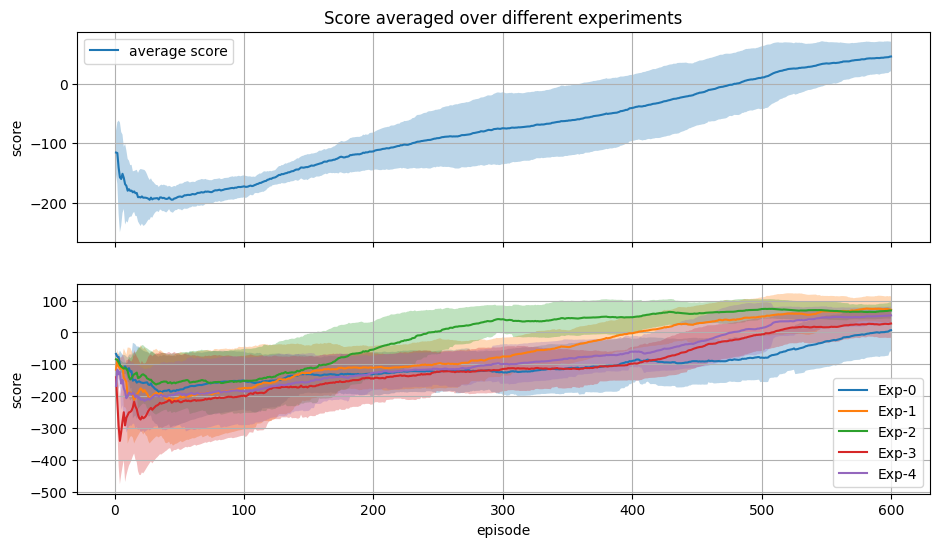

In [19]:
plot_results(avg_scores, std_scores)

## Conclusion
In the aforementioned notebook, we have seen implementations for the *REINFORCE* and *REINFORCE with baseline* algorithms as they were introduced in [1] (Chapters 13.3 and 13.4).
It is easy to see from the comparison of the two results plots, that *REINFORCE with baseline* has lower variance than the original *REINFORCE* algorithm. Although not being used in the *choose action* process of the agent, the parametrized learned value function contributes to the stability of the algorithm and results in a much cleaner training process. The next improvement would be to actually consider the value function in choosing the next action with the agent's policy. In that case we will end up with the so-called *Actor-Critic* algorithm, where the Actor is given by the policy network, and the Critic is given by the value network.

## References
[1] Sutton & Barto, Reinforcement Learning An Introduction -Second edition (2018)

## Contact
If you have any comments, corrections or questions about the material presented in the notebook, please do not hesitate to email me at elkabetz.roy@gmail.com